# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. twitter_id -- идентификатор пользователя
2. class -- числовой номер класса

In [2]:
TRAINING_SET_URL = "twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",")
df_users.head()

,twitter_id,is_1,is_2,is_3
0,66412773,0,0,1
1,10143902,0,0,1
2,73701917,0,0,1
3,82209363,0,0,1
4,47063951,0,0,1


Построим распределение по классам. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (1, 2 и 3), а по вертикальной -- количество пользователей.

[1270, 479, 1251]


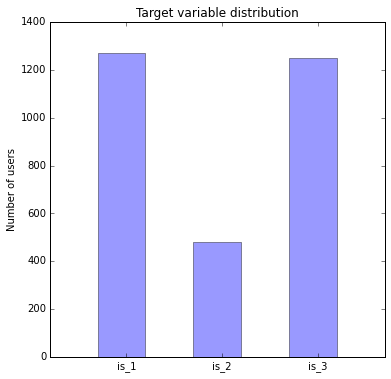

In [3]:
# Compute the distribution of the target variable

counts = [sum(df_users["is_1"]), sum(df_users["is_2"]), sum(df_users["is_3"])]
bins = [0, 1, 2]
print counts

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins, counts, width=0.5, alpha=0.4)
pl.xticks([b + 0.3 for b in bins], ["is_1", "is_2", "is_3"])
pl.xlim(bins[0] - 0.5, bins[-1] + 1)
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что user_id для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя. Кроме того, количество запросов ограничено 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию `get_coordinates_by_location`, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [5]:
# NOTE: In tutor above, you say that http://api.geonames.org/search?... returns JSON, but it returns XML.
# NOTE: Used .../searchJSON?... to get JSON answer
GEO_USER_NAME = "ospanoff"

def get_coordinates_by_location(location):
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    """
    keys = {'q' : location, 'maxRows' : 1, 'username' : GEO_USER_NAME}
    r = requests.get('http://api.geonames.org/searchJSON', params=keys).json()['geonames']
    if (len(r) > 0): # Geonames can not find some locations or wrong loc
        r = r[0]
        return (float(r['lat']), float(r['lng']), r['countryName'])
    else:
        return (np.NaN, np.NaN, np.NaN)

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (5 баллов).

In [6]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

def twitter_user_to_dataframe_record(user):
    record = {
        "twitter_id": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": ts_parser(user.created_at),        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record

def get_user_records(df):
    
    MUPR = 100 # max user per request for twitter api
    ids = list(set(df['twitter_id'].values)) # to delete same user ids
    users = []

    for i in range(len(ids) // MUPR + (len(ids) % MUPR != 0)):
        tmp = api.UsersLookup(ids[i * MUPR: (i + 1) * MUPR])
        for u in tmp:
            users.append(twitter_user_to_dataframe_record(u))
    
    return users

%time user_records = get_user_records(df_users)

print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["twitter_id", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="twitter_id", how="left")
print "Finished building data frame"

CPU times: user 8.93 s, sys: 688 ms, total: 9.62 s
Wall time: 8min 46s
Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю пользователей каждого класса в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю пользователей класса ([подсказка](http://anokhin.github.io/img/hw1_distr.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (2 балла).

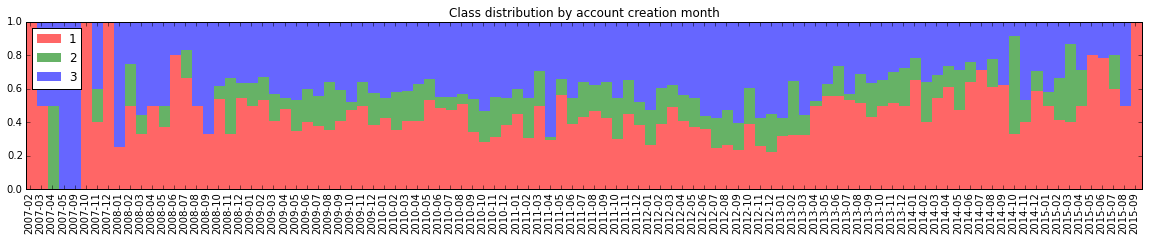

In [7]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_1 -- 1D numpy array with the counts of is_1 users created at each date
        count_2 -- 1D numpy array with the counts of is_2 users created at each date
        count_3 -- 1D numpy array with the counts of is_3 users created at each date
        dts -- a list of date strings, e.g. ['2014-10-11', '2014-10-12', ...]
    """
    tmp = grouped.sum()
    dts = tmp.index[:-1] # don't take NA
    count_1, count_2, count_3 = tmp['is_1'], tmp['is_2'], tmp['is_3']
    return count_1, count_2, count_3, dts


grouped = df_full.groupby(map(lambda dt: dt.strftime("%Y-%m") if pd.notnull(dt) else "NA", df_full["created_at"]))
count_1, count_2, count_3, dts = count_users(grouped)
    
total = (count_1 + count_2 + count_3 + 1e-10)
fraction_1 = count_1 / total
fraction_2 = count_2 / total
fraction_3 = count_3 / total

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_1[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="1")
pl.bar(np.arange(len(dts)), fraction_2[sort_ind], bottom=fraction_1[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="2")
pl.bar(np.arange(len(dts)), fraction_3[sort_ind], bottom=fraction_2[sort_ind] + fraction_1[sort_ind], width=1.0, color='blue', alpha=0.6, linewidth=0, label="3")

# NOTE: bottom for 3rd plot was fraction2, but it should be fraction1 + fraction2

pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend(loc='best') # NOTE: loc='best' is better than nothing =)
pl.show()

Посмотрим, где живут пользователи каждой категории. Для этого отметим на карте каждого пользователя первого класса красным, второго - зеленым, третьего - синим цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (3 балла).

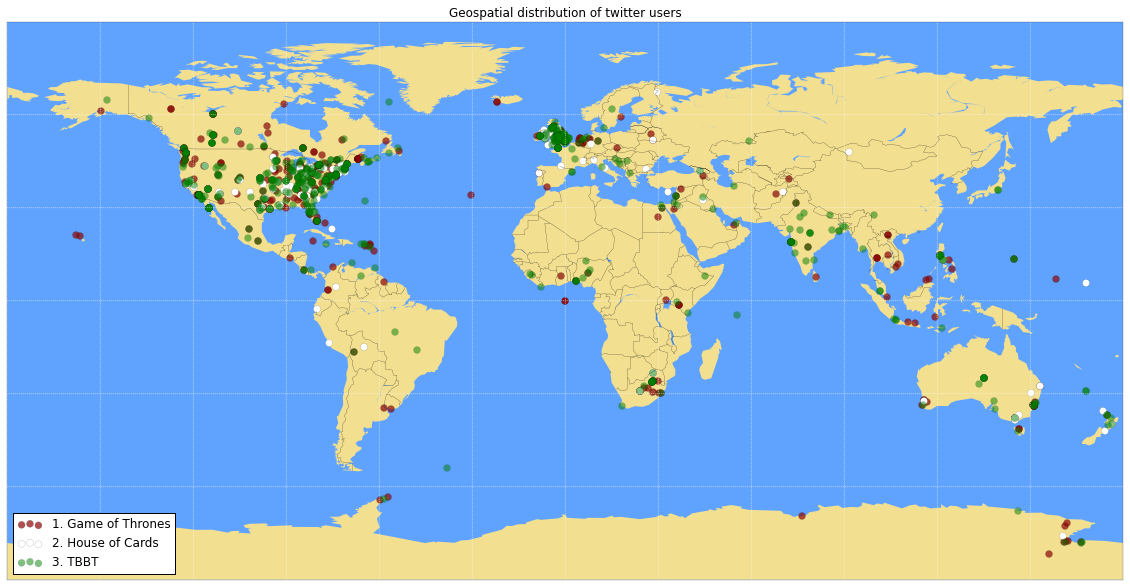

In [10]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='#f2df90', lake_color='#60a3ff', zorder=0)
m.drawmapboundary(linewidth=0.2, fill_color='#60a3ff')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    tmp = df_full[[1, 2, 3, 9, 10]].dropna() # drop NaN
    lons = tmp['lon'].values
    lats = tmp['lat'].values
    is_1 = tmp['is_1'].values.astype(np.bool)
    is_2 = tmp['is_2'].values.astype(np.bool)
    is_3 = tmp['is_3'].values.astype(np.bool)
    x, y = m(lons[is_1], lats[is_1])
    pl.scatter(x, y, c='#8A0707', linewidth=0.1, s=50, alpha=0.7, label='1. Game of Thrones')
    
    x, y = m(lons[is_2], lats[is_2])
    pl.scatter(x, y, c='#ffffff', linewidth=0.1, s=50, alpha=1, label='2. House of Cards')
    
    x, y = m(lons[is_3], lats[is_3])
    pl.scatter(x, y, c='g', linewidth=0.1, s=50, alpha=0.5, label='3. TBBT')
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend(loc='best')
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой.

Смотрим на полученный data frame и сохраняем его в .csv файл.

In [9]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,twitter_id,is_1,is_2,is_3,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,66412773,0,0,1,Fred Stevens,TKeep123,"ONLY 18yo+ to follow me! Reality Show Junkie, ...",False,"East of Atlanta, GA",-84.34493,33.74011,United States,2009-08-17 17:04:39+00:00,1605,1940,50190,489,108
1,10143902,0,0,1,Josh Sheldon,joshsheldon,"Dad, MIT App Inventor & STEP Lab teams, educat...",False,"Cambridge, MA",-71.10561,42.37510,United States,2007-11-11 03:52:31+00:00,586,520,1185,42,53
2,73701917,0,0,1,¡¡¡ Bazinga !!!,tulri,Hello. You've reached the house of unrecognize...,False,NaN,NaN,NaN,NaN,2009-09-12 18:23:20+00:00,1125,98,22099,635,25
3,82209363,0,0,1,Sheldon Williams,Shel_Williams9,18 | Anderson CVI | Boxer fighting out of the ...,False,"Ontario, Canada",-84.49983,49.25014,Canada,2009-10-13 22:28:44+00:00,209,256,8048,5567,1
4,47063951,0,0,1,Tony The Weezle,DopeWeezle,Im just a Material boy living in a Material wo...,False,Las Vegas,-115.13722,36.17497,United States,2009-06-14 09:17:23+00:00,1741,1702,15142,23378,20
